[*********************100%***********************]  1 of 1 completed


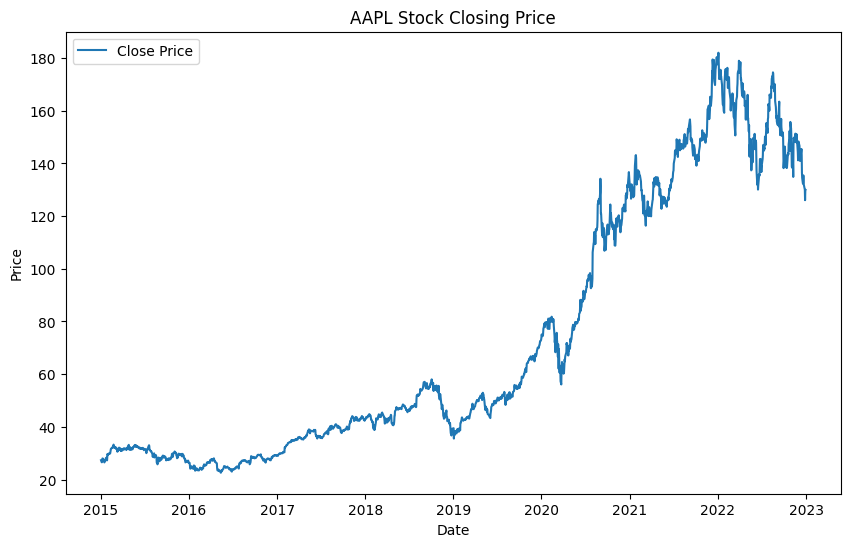

Mean Squared Error: 77.83
Root Mean Squared Error: 8.82
Mean Absolute Error (MAE): 6.18
R² Score: 0.9668


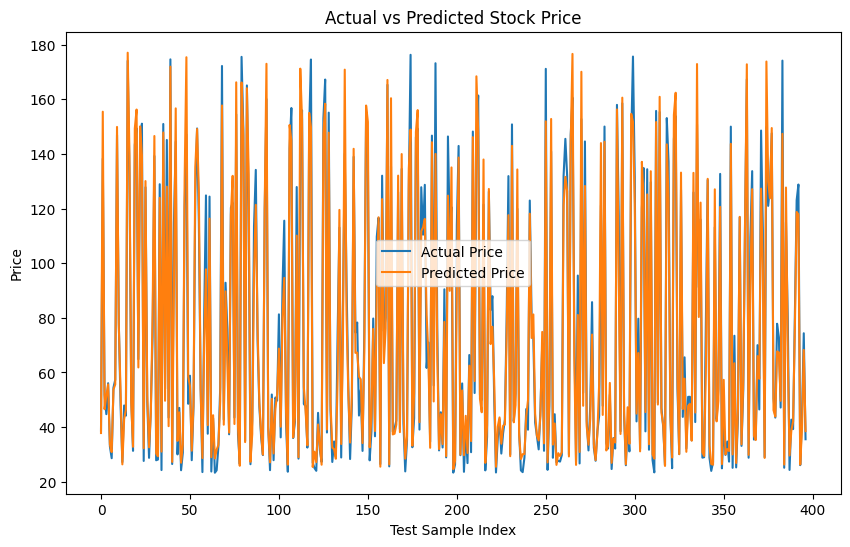

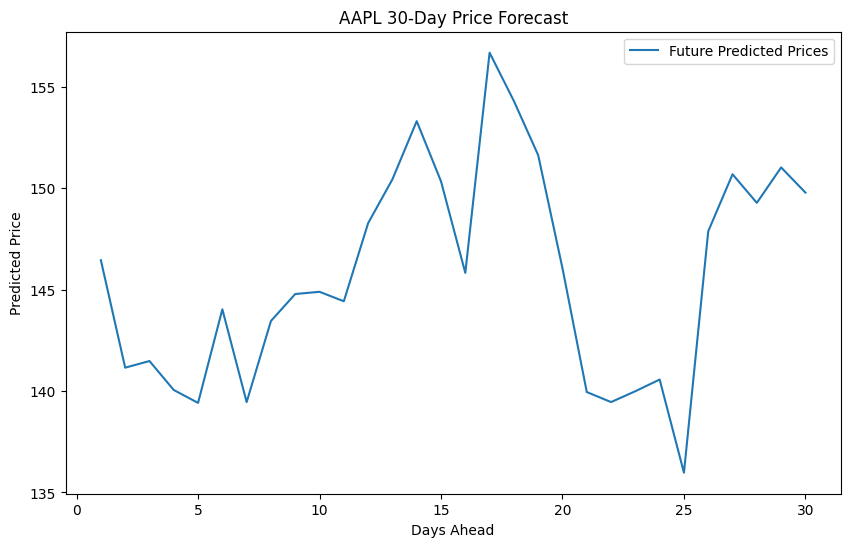

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Download historical stock data
ticker = 'AAPL'  # You can change this to any stock symbol
data = yf.download(ticker, start='2015-01-01', end='2023-01-01')
data = data[['Close']]  # We're interested in the 'Close' price
data.head()

# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{ticker} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Shift the data to create a simple supervised learning problem
data['Prediction'] = data['Close'].shift(-30)  # Predicting 30 days into the future
data.dropna(inplace=True)  # Drop the NaN values created by the shift
data.tail()
# Define features and target
X = np.array(data[['Close']])
y = np.array(data['Prediction'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Compare predictions with actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()
# Create a DataFrame with recent prices to predict the next 30 days
recent_data = data[['Close']].tail(30).to_numpy().reshape(-1, 1)
future_prediction = model.predict(recent_data)

# Plot the prediction
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 31), future_prediction, label='Future Predicted Prices')
plt.title(f'{ticker} 30-Day Price Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


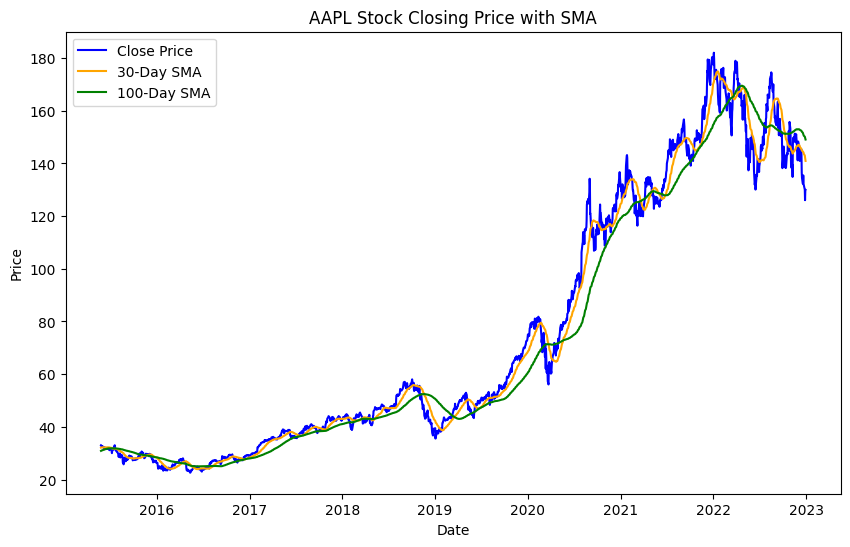

Mean Squared Error: 82.08
Root Mean Squared Error: 9.06
Mean Absolute Error (MAE): 6.10
R² Score: 0.9681


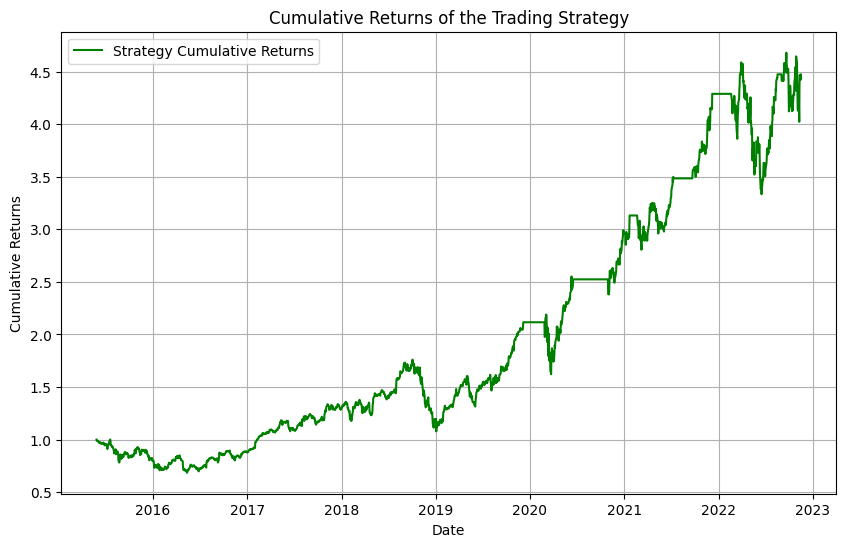

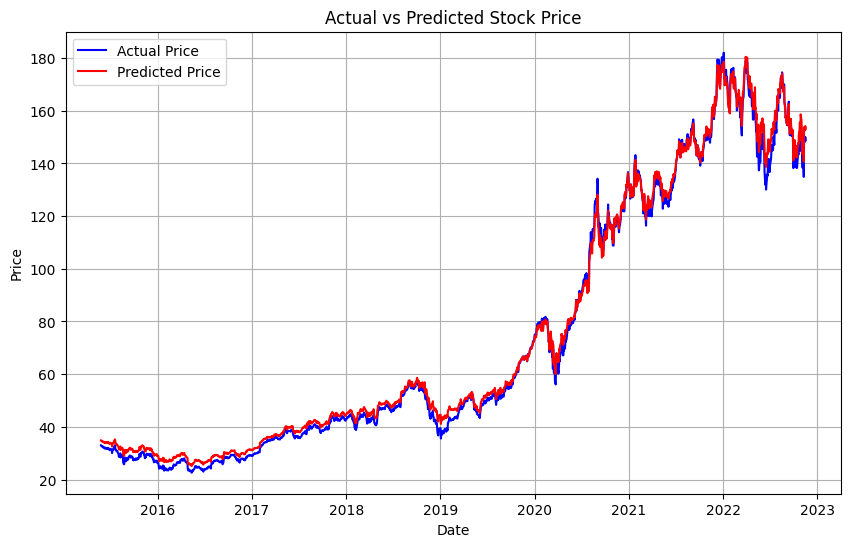

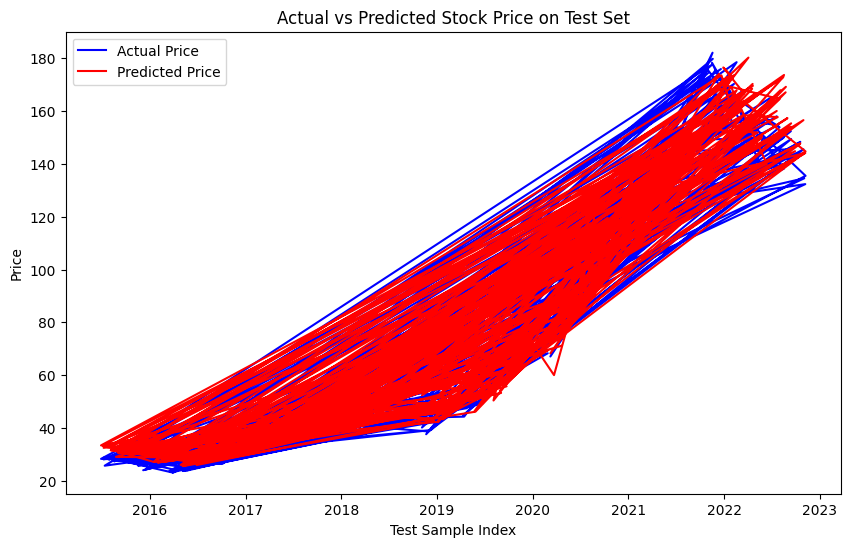

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Download historical stock data
ticker = 'AAPL'  # You can change this to any stock symbol
data = yf.download(ticker, start='2015-01-01', end='2023-01-01')
data = data[['Close']]  # We're interested in the 'Close' price

# Calculate Simple Moving Averages
data['SMA_30'] = data['Close'].rolling(window=30).mean()  # 30-day SMA
data['SMA_100'] = data['Close'].rolling(window=100).mean()  # 100-day SMA

# Drop rows with NaN values caused by SMA calculation
data.dropna(inplace=True)

# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['SMA_30'], label='30-Day SMA', color='orange')
plt.plot(data['SMA_100'], label='100-Day SMA', color='green')
plt.title(f'{ticker} Stock Closing Price with SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Shift the data to create a simple supervised learning problem
data['Prediction'] = data['Close'].shift(-30)  # Predicting 30 days into the future
data.dropna(inplace=True)  # Drop the NaN values created by the shift

# Define features and target
X = data[['Close', 'SMA_30', 'SMA_100']]  # Use DataFrame for features
y = data['Prediction']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Backtesting a simple trading strategy
# Predict the whole dataset using the Linear Regression model
data['Predicted'] = model.predict(data[['Close', 'SMA_30', 'SMA_100']])  # Use all features

# Initialize the Signal column to 0
data['Signal'] = 0  

# Shift predicted values by 1 day for comparison
data['Predicted_Shifted'] = data['Predicted'].shift(1)
data['Close_Shifted'] = data['Close'].shift(1)

# Create buy signals: Buy if the predicted price (shifted) is greater than the previous day's close
data['Signal'] = np.where(data['Predicted_Shifted'] > data['Close_Shifted'], 1, 0)  # Buy signal

# Calculate daily returns
data['Daily_Returns'] = data['Close'].pct_change()

# Calculate strategy returns: Ensure we are multiplying Series
data['Strategy_Returns'] = data['Signal'].shift(1) * data['Daily_Returns']  # Shift the Signal to avoid lookahead bias

# Calculate cumulative returns
cumulative_strategy_returns = (1 + data['Strategy_Returns']).cumprod()

# Plot cumulative returns of the strategy
plt.figure(figsize=(10, 6))
plt.plot(cumulative_strategy_returns, label='Strategy Cumulative Returns', color='g')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

# Optional: Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Actual Price', color='blue')
plt.plot(data['Predicted'], label='Predicted Price', color='red')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Compare predictions with actual prices on the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, predictions, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Stock Price on Test Set')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()